In [2]:
import awkward as ak
import numpy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

fname = "/hdfs/store/user/kaho/NanoPost1/GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8/GluGlu_LFV_HToEMu_M125/210728_002944/0000/tree_1.root"#/hdfs/store/user/kaho/NanoPost1/SingleMuon/SingleMuon_Run2017C-UL2017/210727_235847/0000/tree_50.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/uproot/reading.py:186: FutureWarning: XRootD 4.12.3 is not fully supported; either upgrade to 5.2.0+ or set

    open.defaults["xrootd_handler"] = uproot.MultithreadedXRootDSource

  warnings.warn(message, FutureWarning)
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/si

In [25]:
def pZeta(leg1, leg2, MET_px, MET_py):
    leg1x = numpy.cos(leg1.phi)
    leg2x = numpy.cos(leg2.phi)
    leg1y = numpy.sin(leg1.phi)
    leg2y = numpy.sin(leg2.phi)
    zetaX = leg1x + leg2x
    zetaY = leg1y + leg2y
    zetaR = numpy.sqrt(zetaX*zetaX + zetaY*zetaY)
    
    numpy.where((zetaR > 0.), zetaX/zetaR, zetaX)
    numpy.where((zetaR > 0.), zetaY/zetaR, zetaY)
    zetaX = zetaX/zetaR
    zetaY = zetaY/zetaR
    
    visPx = leg1.px + leg2.px
    visPy = leg1.py + leg2.py
    pZetaVis = visPx*zetaX + visPy*zetaY
    px = visPx + MET_px
    py = visPy + MET_py
    
    pZeta = px*zetaX + py*zetaY
    
    return (pZeta, pZetaVis)

def Rpt(lep1, lep2, jets=None):
    emVar = lep1+lep2
    if jets==None:
        return (emVar).pt/(lep1.pt+lep2.pt)
    elif len(jets)==1:
        return (emVar + jets[0]).pt/(lep1.pt+lep2.pt+jets[0].pt)
    elif len(jets)==2:
        return (emVar + jets[0] +jets[1]).pt/(lep1.pt+lep2.pt+jets[0].pt+jets[1].pt)
    else:
        return -999
    
def Zeppenfeld(lep1, lep2, jets):
    emVar = lep1+lep2
    if len(jets)==1:
        return emVar.eta - (jets[0].eta)/2
    elif len(jets)==2:
        return emVar.eta - (jets[0].eta + jets[1].eta)/2
    else:
        return -999

def mT(lep, met):
    return numpy.sqrt(abs((numpy.sqrt(lep.mass**2+lep.pt**2) + met.pt)**2 - (lep+met).pt**2))

def pt_cen(lep1, lep2, jets):
    emVar = lep1+lep2
    if len(jets)==1:
        return emVar.pt - jets[0].pt/2
    elif len(jets)==2:
        return emVar.pt - (jets[0] + jets[1]).pt/2
    else:
        return -999
        

In [29]:
#Choice em channel and Iso27
emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

E_collections = emevents.Electron
M_collections = emevents.Muon

#Kinematics Selections
emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

E_collections = emevents.Electron[emevents.Electron.Target==1]
M_collections = emevents.Muon[emevents.Muon.Target==1]

#Opposite Charge
E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
opp_charge = ak.flatten(E_charge*M_charge==-1)

emevents = emevents[opp_charge]

#Trig Matching
M_collections = emevents.Muon
trg_collections = emevents.TrigObj

M_collections = M_collections[M_collections.Target==1]
trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)
emevents = emevents[trg_Match]

Electron_collections = emevents.Electron[emevents.Electron.Target==1]
Muon_collections = emevents.Muon[emevents.Muon.Target==1]

MET_collections = emevents.MET
Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]
L_bJet_collections = emevents.Jet[emevents.Jet.passDeepJet_L==1]
M_bJet_collections = emevents.Jet[emevents.Jet.passDeepJet_M==1]

#ensure Jets are pT-ordered
Jet_collections = Jet_collections[ak.argsort(Jet_collections.pt_nom, axis=1, ascending=False)]
L_bJet_collections = L_bJet_collections[ak.argsort(L_bJet_collections.pt, axis=1, ascending=False)]
M_bJet_collections = M_bJet_collections[ak.argsort(M_bJet_collections.pt, axis=1, ascending=False)]

#Jet corrections
Jet_collections['pt'] = Jet_collections['pt_nom']
Jet_collections['mass'] = Jet_collections['mass_nom']

#MET pT corrections
MET_collections['phi'] = MET_collections['T1Smear_phi'] 
MET_collections['pt'] = MET_collections['T1Smear_pt'] \
                        - ak.flatten(Muon_collections['pt']) + ak.flatten(Muon_collections['corrected_pt'])\
                        - ak.flatten(Electron_collections['pt']/Electron_collections['eCorr'])\
                        + ak.flatten(Electron_collections['pt'])
                    
#Muon pT corrections
Muon_collections['pt'] = Muon_collections['corrected_pt']

#Take the first leptons
Electron_collections = Electron_collections[:,0]
Muon_collections = Muon_collections[:,0]
emVar = Electron_collections + Muon_collections

# #one hot encoding for year 
# emevents["year2016preVFP"] = numpy.zeros(len(emevents))
# emevents["year2016postVFP"] = numpy.zeros(len(emevents))
# emevents["year2017"] = numpy.ones(len(emevents))
# emevents["year2018"] = numpy.zeros(len(emevents))

# #label signal
# emevents["label"] = numpy.ones(len(emevents)) if 'LFV' in fname else numpy.zeros(len(emevents))

# var_ = ["met", "eEta", "mEta", "mpt_Per_e_m_Mass", "ept_Per_e_m_Mass", "empt", "emEta", "DeltaEta_e_m", "DeltaPhi_e_m", "DeltaR_e_m", "Rpt_0", "e_met_mT", "m_met_mT", "e_met_mT_Per_e_m_Mass", "m_met_mT_Per_e_m_Mass", "pZeta85", "pZeta15", "pZeta", "pZetaVis"]
# var_1jet_ = ["j1pt", "j1Eta", "DeltaEta_j1_em", "DeltaPhi_j1_em", "DeltaR_j1_em", "Zeppenfeld", "Rpt_1"]
# var_2jet_ = ["j2pt", "j2Eta", "j1_j2_mass", "DeltaEta_em_j1j2", "DeltaPhi_em_j1j2", "DeltaR_em_j1j2", "DeltaEta_j1_em", "DeltaPhi_j1_em", "DeltaR_j1_em", "DeltaEta_j2_em", "DeltaPhi_j2_em", "DeltaR_j2_em", "DeltaEta_j1_j2", "DeltaPhi_j1_j2", "DeltaR_j1_j2", "Zeppenfeld", "Zeppenfeld_DeltaEta", "absZeppenfeld_DeltaEta", "cen", "Rpt", "pt_cen", "pt_cen_Deltapt", "abspt_cen_Deltapt", "Ht_had", "Ht"]

# #make interesting variables
# #zero/any no. of jets
# emevents["eEta"] = Electron_collections.eta
# emevents["mEta"] = Muon_collections.eta
# emevents["mpt_Per_e_m_Mass"] = Muon_collections.pt/emVar.mass
# emevents["ept_Per_e_m_Mass"] = Electron_collections.pt/emVar.mass
# emevents["empt"] = emVar.pt
# emevents["emEta"] = emVar.eta
# emevents["DeltaEta_e_m"] = abs(Muon_collections.eta - Electron_collections.eta)
# emevents["DeltaPhi_e_m"] = Muon_collections.delta_phi(Electron_collections)
# emevents["DeltaR_e_m"] = Muon_collections.delta_r(Electron_collections)
# emevents["Rpt_0"] = Rpt(Muon_collections, Electron_collections)

# emevents["met"] = MET_collections.pt

# emevents["e_met_mT"] = mT(Electron_collections, MET_collections)
# emevents["m_met_mT"] = mT(Muon_collections, MET_collections)
# emevents["e_met_mT_Per_e_m_Mass"] = emevents["e_met_mT"]/emVar.mass
# emevents["m_met_mT_Per_e_m_Mass"] = emevents["m_met_mT"]/emVar.mass

# pZeta_, pZetaVis_ = pZeta(Muon_collections, Electron_collections,  MET_collections.px,  MET_collections.py)
# emevents["pZeta85"] = pZeta_ - 0.85*pZetaVis_
# emevents["pZeta15"] = pZeta_ - 1.5*pZetaVis_
# emevents["pZeta"] = pZeta_
# emevents["pZetaVis"] = pZetaVis_

# #one jets
# onejets_emevents = emevents[emevents.nJet30 >= 1]
# Electron_collections_1jet = Electron_collections[emevents.nJet30 >= 1]
# Muon_collections_1jet = Muon_collections[emevents.nJet30 >= 1]
# emVar_1jet = Electron_collections_1jet + Muon_collections_1jet

# onejets_emevents['j1pt'] = Jet_collections[emevents.nJet30 >= 1][:,0].pt
# onejets_emevents['j1Eta'] = Jet_collections[emevents.nJet30 >= 1][:,0].eta

# onejets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 1][:,0].eta - emVar_1jet.eta)
# onejets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_phi(emVar_1jet)
# onejets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_r(emVar_1jet)

# onejets_emevents["Zeppenfeld"] = Zeppenfeld(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])
# onejets_emevents["Rpt_1"] = Rpt(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])

# #2 or more jets
# Multijets_emevents = emevents[emevents.nJet30 >= 2]

# Electron_collections_2jet = Electron_collections[emevents.nJet30 >= 2]
# Muon_collections_2jet = Muon_collections[emevents.nJet30 >= 2]
# emVar_2jet = Electron_collections_2jet + Muon_collections_2jet

# MET_collections_2jet = MET_collections[emevents.nJet30 >= 2]

# Multijets_emevents['j2pt'] = Jet_collections[emevents.nJet30 >= 2][:,1].pt
# Multijets_emevents['j2Eta'] = Jet_collections[emevents.nJet30 >= 2][:,1].eta
# Multijets_emevents["j1_j2_mass"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).mass

# Multijets_emevents["DeltaEta_em_j1j2"] = abs((Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).eta - emVar_2jet.eta)
# Multijets_emevents["DeltaPhi_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_phi(emVar_2jet)
# Multijets_emevents["DeltaR_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_r(emVar_2jet)

# Multijets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - emVar_2jet.eta)
# Multijets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(emVar_2jet)
# Multijets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(emVar_2jet)
# Multijets_emevents["DeltaEta_j2_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,1].eta - emVar_2jet.eta)
# Multijets_emevents["DeltaPhi_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_phi(emVar_2jet)
# Multijets_emevents["DeltaR_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_r(emVar_2jet)

# Multijets_emevents["DeltaEta_j1_j2"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - Jet_collections[emevents.nJet30 >= 2][:,1].eta)
# Multijets_emevents["DeltaPhi_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(Jet_collections[emevents.nJet30 >= 2][:,1])
# Multijets_emevents["DeltaR_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(Jet_collections[emevents.nJet30 >= 2][:,1])

# Multijets_emevents["Zeppenfeld"] = Zeppenfeld(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
# Multijets_emevents["Zeppenfeld_DeltaEta"] = Multijets_emevents["Zeppenfeld"]/Multijets_emevents["DeltaEta_j1_j2"]
# Multijets_emevents["absZeppenfeld_DeltaEta"] = abs(Multijets_emevents["Zeppenfeld_DeltaEta"])
# Multijets_emevents["cen"] = numpy.exp(-4*Multijets_emevents["Zeppenfeld_DeltaEta"]**2)

# Multijets_emevents["Rpt"] = Rpt(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])

# Multijets_emevents["pt_cen"] = pt_cen(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
# Multijets_emevents["pt_cen_Deltapt"] = Multijets_emevents["pt_cen"]/(Jet_collections[emevents.nJet30 >= 2][:,0] - Jet_collections[emevents.nJet30 >= 2][:,1]).pt
# Multijets_emevents["abspt_cen_Deltapt"] = abs(Multijets_emevents["pt_cen_Deltapt"])

# Multijets_emevents["Ht_had"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt
# Multijets_emevents["Ht"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt

#Get bTag SF
bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

#PU/PF/Gen Weights
SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

#Muon SF
SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

#Electron SF
SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF

emevents["SF"] = SF
#emu = Electron_collections[:,0] + Muon_collections[:,0]


[19.4, 19.8, 19, 20.6, 19.8, 20.9, 15, ... 19.1, 19.8, 20.2, 20, 19.7, 21.7, 18.9]


In [5]:
#Write csv files
import pandas as pd
from coffea import processor

#0jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 == 1][var])
df = pd.DataFrame(var_dict)
df.to_csv('out_0jets.csv')

#1jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 >= 1][var])
for var in var_1jet_ :
  var_dict[var] = ak.to_list(onejets_emevents[var])
df = pd.DataFrame(var_dict)
df.to_csv('out_1jets.csv')

#2jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 >= 2][var])
for var in var_1jet_ :
  var_dict[var] = ak.to_list(onejets_emevents[onejets_emevents.nJet30 >= 2][var])
for var in var_2jet_ :
  var_dict[var] = ak.to_list(Multijets_emevents[var])
df = pd.DataFrame(var_dict)
df.to_csv('out_2jets.csv')



In [4]:
del events
del emevents
del emu

NameError: name 'emu' is not defined

In [85]:
from coffea import processor
import numpy
class MyDF(processor.ProcessorABC):
    def __init__(self, lumiWeight):
        self._lumiWeight = lumiWeight
        self._accumulator = processor.dict_accumulator({})
        self.var_ = ["label", "weight", "met", "eEta", "mEta", "mpt_Per_e_m_Mass", "ept_Per_e_m_Mass", "empt", "emEta", "DeltaEta_e_m", "DeltaPhi_e_m", "DeltaR_e_m", "Rpt_0", "e_met_mT", "m_met_mT", "e_met_mT_Per_e_m_Mass", "m_met_mT_Per_e_m_Mass", "pZeta85", "pZeta15", "pZeta", "pZetaVis"]
        self.var_1jet_ = ["j1pt", "j1Eta", "DeltaEta_j1_em", "DeltaPhi_j1_em", "DeltaR_j1_em", "Zeppenfeld_1", "Rpt_1"]
        self.var_2jet_ = ["j2pt", "j2Eta", "j1_j2_mass", "DeltaEta_em_j1j2", "DeltaPhi_em_j1j2", "DeltaR_em_j1j2", "DeltaEta_j2_em", "DeltaPhi_j2_em", "DeltaR_j2_em", "DeltaEta_j1_j2", "DeltaPhi_j1_j2", "DeltaR_j1_j2", "Zeppenfeld", "Zeppenfeld_DeltaEta", "absZeppenfeld_DeltaEta", "cen", "Rpt", "pt_cen", "pt_cen_Deltapt", "abspt_cen_Deltapt", "Ht_had", "Ht"]
        for var in self.var_ :
            self._accumulator[var+'_0jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_1jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
        for var in self.var_1jet_ :
            self._accumulator[var+'_1jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
        for var in self.var_2jet_ :
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
    @property
    def accumulator(self):
        return self._accumulator
    
    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

        return emevents[trg_Match]
    
    def SF(self, emevents):
        if emevents.metadata["dataset"]=='data': return numpy.ones(len(emevents))
        #Get bTag SF
        bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
        bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

        #PU/PF/Gen Weights
        SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        
        #Muon SF
        SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

        #Electron SF
        SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF
        
        emevents["weight"] = ak.flatten(SF)*self._lumiWeight[emevents.metadata["dataset"]]
        emevents["label"] = numpy.ones(len(emevents), dtype=numpy.bool_) if 'LFV' in emevents.metadata["dataset"] else numpy.zeros(len(emevents), dtype=numpy.bool_)
        
        return emevents
    
    def interesting(self, emevents):
        #make interesting variables
        #zero/any no. of jets
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        Muon_collections = emevents.Muon[emevents.Muon.Target==1]

        MET_collections = emevents.MET
        Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]
        L_bJet_collections = emevents.Jet[emevents.Jet.passDeepJet_L==1]
        M_bJet_collections = emevents.Jet[emevents.Jet.passDeepJet_M==1]

        #ensure Jets are pT-ordered
        Jet_collections = Jet_collections[ak.argsort(Jet_collections.pt_nom, axis=1, ascending=False)]
        L_bJet_collections = L_bJet_collections[ak.argsort(L_bJet_collections.pt, axis=1, ascending=False)]
        M_bJet_collections = M_bJet_collections[ak.argsort(M_bJet_collections.pt, axis=1, ascending=False)]

        #Jet corrections
        Jet_collections['pt'] = Jet_collections['pt_nom']
        Jet_collections['mass'] = Jet_collections['mass_nom']

        #MET pT corrections
        MET_collections['phi'] = MET_collections['T1Smear_phi'] 
        MET_collections['pt'] = MET_collections['T1Smear_pt'] \
                                - ak.flatten(Muon_collections['pt']) + ak.flatten(Muon_collections['corrected_pt'])\
                                - ak.flatten(Electron_collections['pt']/Electron_collections['eCorr'])\
                                + ak.flatten(Electron_collections['pt'])

        #Muon pT corrections
        Muon_collections['pt'] = Muon_collections['corrected_pt']

        #Take the first leptons
        Electron_collections = Electron_collections[:,0]
        Muon_collections = Muon_collections[:,0]
        emVar = Electron_collections + Muon_collections
        emevents["eEta"] = Electron_collections.eta
        emevents["mEta"] = Muon_collections.eta
        emevents["mpt_Per_e_m_Mass"] = Muon_collections.pt/emVar.mass
        emevents["ept_Per_e_m_Mass"] = Electron_collections.pt/emVar.mass
        emevents["empt"] = emVar.pt
        emevents["emEta"] = emVar.eta
        emevents["DeltaEta_e_m"] = abs(Muon_collections.eta - Electron_collections.eta)
        emevents["DeltaPhi_e_m"] = Muon_collections.delta_phi(Electron_collections)
        emevents["DeltaR_e_m"] = Muon_collections.delta_r(Electron_collections)
        emevents["Rpt_0"] = Rpt(Muon_collections, Electron_collections)

        emevents["met"] = MET_collections.pt

        emevents["e_met_mT"] = mT(Electron_collections, MET_collections)
        emevents["m_met_mT"] = mT(Muon_collections, MET_collections)
        emevents["e_met_mT_Per_e_m_Mass"] = emevents["e_met_mT"]/emVar.mass
        emevents["m_met_mT_Per_e_m_Mass"] = emevents["m_met_mT"]/emVar.mass

        pZeta_, pZetaVis_ = pZeta(Muon_collections, Electron_collections,  MET_collections.px,  MET_collections.py)
        emevents["pZeta85"] = pZeta_ - 0.85*pZetaVis_
        emevents["pZeta15"] = pZeta_ - 1.5*pZetaVis_
        emevents["pZeta"] = pZeta_
        emevents["pZetaVis"] = pZetaVis_

        #one jets
        onejets_emevents = emevents[emevents.nJet30 >= 1]
        Electron_collections_1jet = Electron_collections[emevents.nJet30 >= 1]
        Muon_collections_1jet = Muon_collections[emevents.nJet30 >= 1]
        emVar_1jet = Electron_collections_1jet + Muon_collections_1jet

        onejets_emevents['j1pt'] = Jet_collections[emevents.nJet30 >= 1][:,0].pt
        onejets_emevents['j1Eta'] = Jet_collections[emevents.nJet30 >= 1][:,0].eta

        onejets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 1][:,0].eta - emVar_1jet.eta)
        onejets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_phi(emVar_1jet)
        onejets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_r(emVar_1jet)

        onejets_emevents["Zeppenfeld_1"] = Zeppenfeld(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])
        onejets_emevents["Rpt_1"] = Rpt(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])

        #2 or more jets
        Multijets_emevents = emevents[emevents.nJet30 >= 2]

        Electron_collections_2jet = Electron_collections[emevents.nJet30 >= 2]
        Muon_collections_2jet = Muon_collections[emevents.nJet30 >= 2]
        emVar_2jet = Electron_collections_2jet + Muon_collections_2jet

        MET_collections_2jet = MET_collections[emevents.nJet30 >= 2]

        Multijets_emevents['j2pt'] = Jet_collections[emevents.nJet30 >= 2][:,1].pt
        Multijets_emevents['j2Eta'] = Jet_collections[emevents.nJet30 >= 2][:,1].eta
        Multijets_emevents["j1_j2_mass"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).mass

        Multijets_emevents["DeltaEta_em_j1j2"] = abs((Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_r(emVar_2jet)

        Multijets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(emVar_2jet)
        Multijets_emevents["DeltaEta_j2_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,1].eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_r(emVar_2jet)

        Multijets_emevents["DeltaEta_j1_j2"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - Jet_collections[emevents.nJet30 >= 2][:,1].eta)
        Multijets_emevents["DeltaPhi_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(Jet_collections[emevents.nJet30 >= 2][:,1])
        Multijets_emevents["DeltaR_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(Jet_collections[emevents.nJet30 >= 2][:,1])

        Multijets_emevents["Zeppenfeld"] = Zeppenfeld(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
        Multijets_emevents["Zeppenfeld_DeltaEta"] = Multijets_emevents["Zeppenfeld"]/Multijets_emevents["DeltaEta_j1_j2"]
        Multijets_emevents["absZeppenfeld_DeltaEta"] = abs(Multijets_emevents["Zeppenfeld_DeltaEta"])
        Multijets_emevents["cen"] = numpy.exp(-4*Multijets_emevents["Zeppenfeld_DeltaEta"]**2)

        Multijets_emevents["Rpt"] = Rpt(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])

        Multijets_emevents["pt_cen"] = pt_cen(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
        Multijets_emevents["pt_cen_Deltapt"] = Multijets_emevents["pt_cen"]/(Jet_collections[emevents.nJet30 >= 2][:,0] - Jet_collections[emevents.nJet30 >= 2][:,1]).pt
        Multijets_emevents["abspt_cen_Deltapt"] = abs(Multijets_emevents["pt_cen_Deltapt"])

        Multijets_emevents["Ht_had"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt
        Multijets_emevents["Ht"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt
        return emevents, onejets_emevents, Multijets_emevents

    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emevents = self.Vetos(events)
        emevents = self.SF(emevents)
        emevents, onejets_emevents, Multijets_emevents = self.interesting(emevents)
        for var in self.var_ :
            out[var+'_0jets'].add( processor.column_accumulator( emevents[emevents.nJet30 == 0][var].to_numpy() ) )

        for var in self.var_ :
            out[var+'_1jets'].add( processor.column_accumulator( emevents[emevents.nJet30 >= 1][var].to_numpy() ) )
        for var in self.var_1jet_ :
            out[var+'_1jets'].add( processor.column_accumulator( onejets_emevents[var].to_numpy() ) )

        for var in self.var_ :
            out[var+'_2jets'].add( processor.column_accumulator( emevents[emevents.nJet30 >= 2][var].to_numpy() ) )
        for var in self.var_1jet_ :
            out[var+'_2jets'].add( processor.column_accumulator( onejets_emevents[onejets_emevents.nJet30 >= 2][var].to_numpy() ) )
        for var in self.var_2jet_ :
            out[var+'_2jets'].add( processor.column_accumulator( Multijets_emevents[var].to_numpy() ) )
 
        return out

    def postprocess(self, accumulator):
        return accumulator


In [86]:
import glob
import os
import json
import time
year = '2017'
with open('lumi_'+year+'.json') as f:
    lumiWeight = json.load(f)
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)

samples = {}

for samples_shorthand in lumiWeight:
    samples[samples_shorthand] = glob.glob('/hdfs/store/user/kaho/NanoPost1/'+samples_shorthand+'*/*/*/*/*root')

#samples['data'] = glob.glob('/hdfs/store/user/kaho/NanoPost1/SingleMuon/*/*/*/*root')

t1_start = time.time()
result = processor.run_uproot_job(
    samples,
    "Events",
    MyDF(lumiWeight),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = time.time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


Processing:   0%|          | 0/7 [00:00<?, ?chunk/s]

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cro

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-referen

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross

Elapsed time: 15.976332664489746


In [102]:
from coffea.util import load
import pandas as pd
import uproot3
var_dict = [{}, {}, {}]
var_tree = [{}, {}, {}]
result = load("results/2017/makeDF/output.coffea")[0]
for varName in result:
    if '0jets' in varName:
        var_dict[0][varName.replace('_0jets','')] = result[varName].value
        var_tree[0][varName.replace('_0jets','')] = result[varName].value.dtype
    if '1jets' in varName:
        var_dict[1][varName.replace('_1jets','')] = result[varName].value
    if '2jets' in varName:
        var_dict[2][varName.replace('_2jets','')] = result[varName].value


fout = uproot3.recreate('output.root')
fout['tree'] = uproot3.newtree(var_tree[0])
fout['tree'].extend(var_dict[0])
fout.close()
print (type(result['label_0jets'].value.dtype))
# for i in var_dict[2]:
#     print(i) 
#     print(var_dict[2][i].dtype)
# for i in range(3):
#     df = pd.DataFrame(var_dict[i])
#     df.to_csv('out_'+str(i)+'jets.csv')

<class 'numpy.dtype'>


AttributeError: 'newtree' object has no attribute 'fields'

In [3]:
from coffea import processor, hist
import numpy
class MyEMuPeak(processor.ProcessorABC):
    def __init__(self, lumiWeight):
        self._lumiWeight = lumiWeight
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "samples"),
            hist.Bin("emumass", "e_mu mass", 50, 110, 160),
            hist.Bin("ept", "e pt", 40, 24, 200),
        )

    @property
    def accumulator(self):
        return self._histo
    
    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

        return emevents[trg_Match]
    
    def SF(self, emevents):
        if emevents.metadata["dataset"]=='data': return numpy.ones(len(emevents))
        #Get bTag SF
        bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
        bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

        #PU/PF/Gen Weights
        SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        
        #Muon SF
        SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

        #Electron SF
        SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF
        
        return ak.flatten(SF)*self._lumiWeight[emevents.metadata["dataset"]]
        
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emevents = self.Vetos(events)
        emu = emevents.Muon[:,0] + emevents.Electron[:,0]
        weight = self.SF(emevents)
        out.fill(
            dataset=emevents.metadata["dataset"],
            emumass=emu.mass, 
            ept=emevents.Electron[:,0].pt,
            weight=weight
        )
        return out

    def postprocess(self, accumulator):
        return accumulator

In [4]:
import glob
import os
import time
import json
year = '2017'
with open('lumi_'+year+'.json') as f:
    lumiWeight = json.load(f)
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)
samples = {}

for samples_shorthand in lumiWeight:
    samples[samples_shorthand] = glob.glob('/hdfs/store/user/kaho/NanoPost1/'+samples_shorthand+'*/*/*/*/*root')

#samples['data'] = glob.glob('/hdfs/store/user/kaho/NanoPost1/SingleMuon/*/*/*/*root')

t1_start = time.time()
result = processor.run_uproot_job(
    samples,
    "Events",
    MyEMuPeak(lumiWeight),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = time.time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


Preprocessing:   0%|          | 0/7 [00:00<?, ?file/s]

Processing:   0%|          | 0/7 [00:00<?, ?chunk/s]

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missin

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-re

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv/lib/python3.7/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing c

Elapsed time: 6.394823789596558


In [5]:
from coffea.util import save, load
save(result, "output.coffea")

In [ ]:
from coffea.util import save, load
from coffea import hist
histo = load("output.coffea")

%matplotlib inline
#hist.plot1d(result.integrate('ept').integrate('dataset', 'GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8'))
hist.plot1d(histo['GluGlu_LFV_HToEMu'])
#hist.plot1d(histo.integrate('emumass')['data']) #.integrate('dataset', 'data'))

#hist.plot2d(histo.integrate('dataset'), xaxis='ept')
#print(histo.identifiers('dataset'))
#hist.plot1d(result['dataset']['GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8'].integrate('ept'))

<Hist (dataset,emumass,ept) instance at 0x7f8697fadbd0>


In [ ]:
import uproot3

fout = uproot3.recreate('output.root')

a = result.integrate('dataset', 'GluGlu_LFV_HToEMu').to_boost()
b = result.integrate('dataset', 'GluGlu_LFV_HToEMu').integrate('ept').to_boost()

fout['GluGlu_LFV_HToEMu_1d'] =  b.to_numpy()
fout['GluGlu_LFV_HToEMu_2d'] =  a.to_numpy()

fout.close()

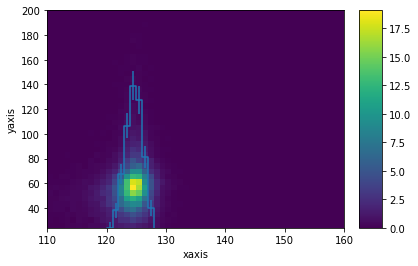

In [129]:
import uproot
fout = uproot.open('output.root')
fout['GluGlu_LFV_HToEMu_1d'].to_hist().plot()
#print(type(fout['GluGlu_LFV_HToEMu_1d'].to_hist()))
fout['GluGlu_LFV_HToEMu_2d'].to_hist().plot() #.show()
fout.close()